# HMS Version 3.x to 4.x Conversion Workflow

This notebook demonstrates how to convert an HMS 3.x project to run with HMS 4.x, with comprehensive QAQC documentation following the **LLM Forward Approach**.

## LLM Forward QAQC Requirements

1. **Modeling Change Log** - Document all modifications made during conversion
2. **Results Comparison** - Compare outputs between original (3.x) and converted (4.x) versions
3. **Visual Verification** - Generate hydrograph comparison figures
4. **Difference Flagging** - Identify any discrepancies for engineer review
5. **Comprehensive Coverage** - Compare ALL hydrological elements (subbasins, reaches, junctions)

## Background

HEC-HMS version 3.x projects may encounter compatibility issues when opened in HMS 4.x:

| Issue | HMS 3.x | HMS 4.x | Impact on Results |
|-------|---------|---------|-------------------|
| Met model basin reference | Pattern matching | Exact name required | None (structural) |
| Cross-section table case | Case-insensitive | Case-sensitive | None (structural) |
| Muskingum Cunge params | Optional | Required | **Potential** (hydraulic) |
| Jython syntax | Python 2 | Python 3 | None (execution) |

This example uses the Clear Creek (A100-00-00) project from the HCFCD M3 Model archives.

In [1]:
# pip install hms-commander

**For Development**: If working on hms-commander source code, use the `hmscmdr_local` conda environment.

In [2]:
from pathlib import Path
from datetime import datetime
import shutil
import json

import pandas as pd
import numpy as np

from hms_commander import HmsM3Model, HmsJython

# For plotting
try:
    import matplotlib.pyplot as plt
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False
    print("matplotlib not installed - figures will be skipped")

## Initialize Modeling Change Log

All modifications will be documented in this log for QAQC purposes.

In [3]:
# Initialize modeling change log
modeling_log = {
    "project_name": "A100-00-00 (Clear Creek)",
    "conversion_date": datetime.now().isoformat(),
    "source_version": "HMS 3.3",
    "target_version": "HMS 4.11",
    "engineer": "[To be filled by reviewing engineer]",
    "changes": [],
    "warnings": [],
    "results_comparison": {}
}

def log_change(category, description, file_affected, old_value, new_value, impact="None"):
    """Add a change to the modeling log."""
    change = {
        "category": category,
        "description": description,
        "file": file_affected,
        "old_value": old_value,
        "new_value": new_value,
        "expected_impact": impact,
        "timestamp": datetime.now().isoformat()
    }
    modeling_log["changes"].append(change)
    print(f"[LOG] {category}: {description}")
    print(f"      File: {file_affected}")
    print(f"      Old: {old_value}")
    print(f"      New: {new_value}")
    print(f"      Expected Impact: {impact}")
    print()

def log_warning(message):
    """Add a warning to the modeling log."""
    modeling_log["warnings"].append({
        "message": message,
        "timestamp": datetime.now().isoformat()
    })
    print(f"[WARNING] {message}")

print("Modeling change log initialized.")
print(f"Project: {modeling_log['project_name']}")
print(f"Conversion: {modeling_log['source_version']} -> {modeling_log['target_version']}")

Modeling change log initialized.
Project: A100-00-00 (Clear Creek)
Conversion: HMS 3.3 -> HMS 4.11


## Step 1: Extract HMS 3.x Project

In [ ]:
# Define paths
m3_cache = Path("example_projects/Upgrade_M3_to_4.13")
m3_cache.mkdir(exist_ok=True)

# Extract Clear Creek project (A100-00-00) from Model A archive
# API: HmsM3Model.extract_project(model_id, unit_id, output_path)
print("Extracting Clear Creek (A100-00-00) from M3 archive...")
project_path = HmsM3Model.extract_project(
    model_id="A",           # Model letter
    unit_id="A100-00-00",   # HCFCD unit number
    output_path=m3_cache,   # Where to extract
    overwrite=True          # Overwrite if exists
)
print(f"Project extracted to: {project_path}")

# Store paths for later
# NOTE: HMS 3.x is 32-bit -> Program Files (x86)
#       HMS 4.x is 64-bit -> Program Files
hms_33_path = Path(r"C:/Program Files (x86)/HEC/HEC-HMS/3.3")
hms_411_path = Path(r"C:/Program Files/HEC/HEC-HMS/4.11")

# Check available versions
print(f"\nHMS 3.3 available: {hms_33_path.exists()}")
print(f"HMS 4.11 available: {hms_411_path.exists()}")

2025-12-25 03:46:48 - hms_commander.HmsM3Model - INFO - Retrieved info for project 'A100-00-00'
2025-12-25 03:46:48 - hms_commander.HmsM3Model - INFO - ----- HmsM3Model Extracting Project -----
2025-12-25 03:46:48 - hms_commander.HmsM3Model - INFO - Model: A - Clear Creek
2025-12-25 03:46:48 - hms_commander.HmsM3Model - INFO - Unit: A100-00-00
2025-12-25 03:46:48 - hms_commander.HmsM3Model - INFO - Downloading from: https://files.m3models.org/modellibrary/A_Clear_FEMA_Effective.zip?effectivedate=2022-05-05%2005:00
2025-12-25 03:46:48 - hms_commander.HmsM3Model - INFO - Size: ~0.03 GB


Extracting Clear Creek (A100-00-00) from M3 archive...


2025-12-25 03:46:50 - hms_commander.HmsM3Model - INFO - Downloaded to c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A_Clear_FEMA_Effective.zip
2025-12-25 03:46:50 - hms_commander.HmsM3Model - INFO - Extracting HMS project to c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00...
2025-12-25 03:46:50 - hms_commander.HmsM3Model - INFO - Found inner HMS zip: HEC-HMS/A_A100-00-00.zip
2025-12-25 03:46:51 - hms_commander.HmsM3Model - INFO - Extracted 46 files
2025-12-25 03:46:51 - hms_commander.HmsM3Model - INFO - Successfully extracted to c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00


Project extracted to: c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00

HMS 3.3 available: True
HMS 4.11 available: True


## Step 2: Run Original Project with HMS 3.3 (Baseline)

In [5]:
# Run with HMS 3.3 (native version) - This is our BASELINE
run_name = "1%(100YR)RUN"

if hms_33_path.exists():
    script = HmsJython.generate_compute_script(
        project_path=project_path,
        run_name=run_name,
        python2_compatible=True  # HMS 3.x uses Jython 2.5
    )
    
    print("Executing BASELINE run with HMS 3.3...")
    result_33 = HmsJython.execute_script(
        script_content=script,
        hms_exe_path=hms_33_path,
        working_dir=project_path,
        timeout=300
    )
    
    print(f"\nBaseline Success: {result_33[0]}")
    if "Computation completed" in result_33[1]:
        print("HMS 3.3 baseline run completed successfully.")
        modeling_log["baseline_run"] = {
            "version": "HMS 3.3",
            "run_name": run_name,
            "success": True,
            "dss_file": str(project_path / "A1000000.dss")
        }
else:
    print("HMS 3.3 not installed - cannot establish baseline")
    log_warning("No HMS 3.3 baseline available - comparison will be limited")

2025-12-25 03:46:51 - hms_commander.HmsJython - INFO - Executing HMS 3.3 via direct Java invocation
2025-12-25 03:46:51 - hms_commander.HmsJython - INFO - Script: c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00\hms_script.py
2025-12-25 03:46:51 - hms_commander.HmsJython - INFO - Memory: -Xms32M -Xmx512M
2025-12-25 03:46:51 - hms_commander.HmsJython - INFO - Using HMS 3.x execution path (32-bit Java)


Executing BASELINE run with HMS 3.3...


2025-12-25 03:47:02 - hms_commander.HmsJython - INFO - HMS 3.3 script executed successfully



Baseline Success: True
HMS 3.3 baseline run completed successfully.


## Step 3: Create Copy for HMS 4.11 Conversion

In [6]:
# Create a copy for HMS 4.11 testing
project_411 = project_path.parent / f"{project_path.name}_HMS411"

if project_411.exists():
    shutil.rmtree(project_411)

shutil.copytree(project_path, project_411)
print(f"Created copy for HMS 4.11 testing: {project_411}")

log_change(
    category="Project Setup",
    description="Created project copy for HMS 4.11 conversion",
    file_affected=str(project_411),
    old_value="N/A",
    new_value=f"Copy of {project_path.name}",
    impact="None - working on copy preserves original"
)

Created copy for HMS 4.11 testing: c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00_HMS411
[LOG] Project Setup: Created project copy for HMS 4.11 conversion
      File: c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00_HMS411
      Old: N/A
      New: Copy of A100-00-00
      Expected Impact: None - working on copy preserves original



## Step 4: Apply Conversion Fixes with Full Logging

In [7]:
# Fix 1: Met file basin model reference
print("="*60)
print("FIX 1: Met Model Basin Reference")
print("="*60)

met_file = project_411 / "1__24HR.met"
content = met_file.read_text(encoding='utf-8', errors='ignore')

old_basin_ref = "Use Basin Model: A100"
new_basin_ref = "Use Basin Model: A100_1PCT"

if old_basin_ref in content:
    content = content.replace(old_basin_ref, new_basin_ref)
    met_file.write_text(content, encoding='utf-8')
    
    log_change(
        category="Met Model",
        description="Updated basin model reference from pattern to exact name",
        file_affected="1__24HR.met",
        old_value=old_basin_ref,
        new_value=new_basin_ref,
        impact="None - structural change only, same basin model used"
    )
else:
    print("Basin reference already updated or not found.")

FIX 1: Met Model Basin Reference
[LOG] Met Model: Updated basin model reference from pattern to exact name
      File: 1__24HR.met
      Old: Use Basin Model: A100
      New: Use Basin Model: A100_1PCT
      Expected Impact: None - structural change only, same basin model used



In [8]:
# Fix 2 & 3: Muskingum Cunge parameters
print("="*60)
print("FIX 2 & 3: Muskingum Cunge Cross-Section and Parameters")
print("="*60)

# Document the Muskingum Cunge parameter changes in detail
muskingum_changes = {
    "reach_name": "A1009999_2147_R",
    "routing_method": "Muskingum Cunge",
    "channel_type": "8-point",
    "parameters_preserved": {
        "Length": "17107 ft",
        "Energy Slope": "0.0005",
        "Manning's n (all)": "0.04"
    },
    "parameters_modified": {
        "Cross Section Name": {"old": "Table 5", "new": "TABLE 5", "reason": "Case sensitivity fix"},
        "Manning's n naming": {"old": "Left/Main/Right Overbank", "new": "Mannings n, Left/Right Mannings n", "reason": "HMS 4.x naming convention"}
    },
    "parameters_added": {
        "Index Parameter Type": "Index Celerity",
        "Index Celerity": "5",
        "Space-Time Method": "Automatic DX and DT",
        "Maximum Depth Iterations": "20",
        "Maximum Route Step Iterations": "30"
    }
}

print("\nMuskingum Cunge Parameter Documentation:")
print(f"  Reach: {muskingum_changes['reach_name']}")
print(f"  Method: {muskingum_changes['routing_method']}")
print(f"  Channel: {muskingum_changes['channel_type']}")
print("\n  PRESERVED Parameters (unchanged):")
for param, value in muskingum_changes['parameters_preserved'].items():
    print(f"    {param}: {value}")
print("\n  MODIFIED Parameters:")
for param, details in muskingum_changes['parameters_modified'].items():
    print(f"    {param}: {details['old']} -> {details['new']}")
    print(f"      Reason: {details['reason']}")
print("\n  ADDED Parameters (HMS 4.x requirements):")
for param, value in muskingum_changes['parameters_added'].items():
    print(f"    {param}: {value}")

# Apply the fix
old_muskingum = '''     Route: Muskingum Cunge
     Channel: 8-point
     Length: 17107
     Energy Slope: 0.0005
     Left Overbank Mannings n: 0.04
     Main Channel Mannings n: 0.04
     Right Overbank Mannings n: 0.04
     Cross Section Name: Table 5
     Use Variable Time Step: No
     Channel Loss: None'''

new_muskingum = '''     Route: Muskingum Cunge
     Channel: 8-point
     Length: 17107
     Energy Slope: 0.0005
     Mannings n: 0.04
     Left Mannings n: 0.04
     Right Mannings n: 0.04
     Cross Section Name: TABLE 5
     Initial Variable: Combined Inflow
     Index Parameter Type: Index Celerity
     Index Celerity: 5
     Space-Time Method: Automatic DX and DT
     Maximum Depth Iterations: 20
     Maximum Route Step Iterations: 30
     Channel Loss: None'''

files_modified = []
for basin_file in project_411.glob("*.basin"):
    content = basin_file.read_text(encoding='utf-8', errors='ignore')
    
    if old_muskingum in content:
        new_content = content.replace(old_muskingum, new_muskingum)
        basin_file.write_text(new_content, encoding='utf-8')
        files_modified.append(basin_file.name)

if files_modified:
    log_change(
        category="Reach Routing",
        description="Updated Muskingum Cunge parameters for HMS 4.x compatibility",
        file_affected=", ".join(files_modified),
        old_value="HMS 3.x Muskingum Cunge (Table 5, no Index params)",
        new_value="HMS 4.x Muskingum Cunge (TABLE 5, Index Celerity=5)",
        impact="POTENTIAL - Index Celerity value affects wave speed calculation. Value of 5 fps is typical for natural channels. ENGINEER REVIEW RECOMMENDED."
    )
    
    log_warning(
        "Muskingum Cunge Index Celerity set to 5 fps. This affects wave propagation speed. "
        "Original HMS 3.x model may have used different internal defaults. "
        "COMPARE HYDROGRAPHS AT REACH A1009999_2147_R TO VERIFY."
    )

# Store for later reference
modeling_log["muskingum_cunge_details"] = muskingum_changes

FIX 2 & 3: Muskingum Cunge Cross-Section and Parameters

Muskingum Cunge Parameter Documentation:
  Reach: A1009999_2147_R
  Method: Muskingum Cunge
  Channel: 8-point

  PRESERVED Parameters (unchanged):
    Length: 17107 ft
    Energy Slope: 0.0005
    Manning's n (all): 0.04

  MODIFIED Parameters:
    Cross Section Name: Table 5 -> TABLE 5
      Reason: Case sensitivity fix
    Manning's n naming: Left/Main/Right Overbank -> Mannings n, Left/Right Mannings n
      Reason: HMS 4.x naming convention

  ADDED Parameters (HMS 4.x requirements):
    Index Parameter Type: Index Celerity
    Index Celerity: 5
    Space-Time Method: Automatic DX and DT
    Maximum Depth Iterations: 20
    Maximum Route Step Iterations: 30
[LOG] Reach Routing: Updated Muskingum Cunge parameters for HMS 4.x compatibility
      File: A100_0.2PCT.basin, A100_10PCT.basin, A100_1PCT.basin, A100_2PCT.basin
      Old: HMS 3.x Muskingum Cunge (Table 5, no Index params)
      New: HMS 4.x Muskingum Cunge (TABLE 5, I

## Step 5: Run Converted Project with HMS 4.11

In [9]:
# Run with HMS 4.11
if hms_411_path.exists():
    script = HmsJython.generate_compute_script(
        project_path=project_411,
        run_name=run_name,
        python2_compatible=False
    )
    
    print("Executing CONVERTED run with HMS 4.11...")
    result_411 = HmsJython.execute_script(
        script_content=script,
        hms_exe_path=hms_411_path,
        working_dir=project_411,
        timeout=300
    )
    
    print(f"\nConverted Run Success: {result_411[0]}")
    if "Computation completed" in result_411[1]:
        print("HMS 4.11 converted run completed successfully.")
        modeling_log["converted_run"] = {
            "version": "HMS 4.11",
            "run_name": run_name,
            "success": True,
            "dss_file": str(project_411 / "A1000000.dss")
        }
    else:
        print(f"Run failed: {result_411[1]}")
else:
    print("HMS 4.11 not installed")

2025-12-25 03:47:02 - hms_commander.HmsJython - INFO - Executing HMS 4.11 via direct Java invocation
2025-12-25 03:47:02 - hms_commander.HmsJython - INFO - Script: c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00_HMS411\hms_script.py
2025-12-25 03:47:02 - hms_commander.HmsJython - INFO - Memory: -Xms128M -Xmx4G


Executing CONVERTED run with HMS 4.11...


2025-12-25 03:47:31 - hms_commander.HmsJython - INFO - HMS 4.11 script executed successfully



Converted Run Success: True
HMS 4.11 converted run completed successfully.


## Step 6: Extract and Compare Results

**Critical QAQC Step**: Compare outputs from both versions to verify equivalence.

In [10]:
# Define DSS file paths
dss_33 = project_path / "A1000000.dss"
dss_411 = project_411 / "A1000000.dss"

print("DSS Output Files:")
print(f"  HMS 3.3 Baseline: {dss_33}")
print(f"    Exists: {dss_33.exists()}, Size: {dss_33.stat().st_size if dss_33.exists() else 'N/A':,} bytes")
print(f"  HMS 4.11 Converted: {dss_411}")
print(f"    Exists: {dss_411.exists()}, Size: {dss_411.stat().st_size if dss_411.exists() else 'N/A':,} bytes")

# Note: Full DSS comparison requires pydsstools or similar
# For now, we'll document what SHOULD be compared
print("\n" + "="*60)
print("RESULTS COMPARISON CHECKLIST")
print("="*60)
print("""
The following elements should be compared between HMS 3.3 and 4.11 outputs:

1. SUBBASINS (131 total)
   - Peak outflow (cfs)
   - Time to peak
   - Total runoff volume (ac-ft)
   - Precipitation depth (in)

2. REACHES (94 total, including A1009999_2147_R with Muskingum Cunge)
   - Peak outflow (cfs)
   - Peak inflow (cfs)
   - Time to peak
   - Attenuation (peak reduction)
   - Translation (lag time)

3. JUNCTIONS (multiple)
   - Peak combined flow (cfs)
   - Time to peak

4. OUTLET
   - Peak discharge (cfs)
   - Time to peak
   - Total volume (ac-ft)
   - Full hydrograph comparison

CRITICAL REACH FOR VERIFICATION:
  Reach A1009999_2147_R - Muskingum Cunge routing was modified
  Compare inflow/outflow hydrographs in detail
""")

DSS Output Files:
  HMS 3.3 Baseline: c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00\A1000000.dss
    Exists: True, Size: 95,897,088 bytes
  HMS 4.11 Converted: c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00_HMS411\A1000000.dss
    Exists: True, Size: 107,969,536 bytes

RESULTS COMPARISON CHECKLIST

The following elements should be compared between HMS 3.3 and 4.11 outputs:

1. SUBBASINS (131 total)
   - Peak outflow (cfs)
   - Time to peak
   - Total runoff volume (ac-ft)
   - Precipitation depth (in)

2. REACHES (94 total, including A1009999_2147_R with Muskingum Cunge)
   - Peak outflow (cfs)
   - Peak inflow (cfs)
   - Time to peak
   - Attenuation (peak reduction)
   - Translation (lag time)

3. JUNCTIONS (multiple)
   - Peak combined flow (cfs)
   - Time to peak

4. OUTLET
   - Peak discharge (cfs)
   - Time to peak
   - Total volume (ac-ft)
   - Full hydrograph comparison

CRITICAL REACH FOR VERIFICATION:
  Reach A1009999_2147_R - Muskingum Cunge rout

In [11]:
# Extract and compare DSS results - CRITICAL ELEMENTS ONLY
# Note: Full comparison of 200+ elements requires chunked extraction (future enhancement)
from hms_commander.dss import HmsDss  # DSS operations from consolidated subpackage

print("="*60)
print("DSS RESULTS EXTRACTION")
print("="*60)

# Get DSS info for both files
print("\nHMS 3.3 Baseline DSS:")
info_33 = HmsDss.get_info(dss_33)
print(f"  Paths: {info_33['num_paths']:,}")
print(f"  Size: {info_33['file_size_mb']:.1f} MB")

print("\nHMS 4.11 Converted DSS:")
info_411 = HmsDss.get_info(dss_411)
print(f"  Paths: {info_411['num_paths']:,}")
print(f"  Size: {info_411['file_size_mb']:.1f} MB")

# Get catalog to find specific paths
catalog_33 = HmsDss.get_catalog(dss_33)

# Define CRITICAL elements to compare (based on conversion changes)
critical_elements = [
    'A1000000_0000_J',    # Main outlet junction
    'A1009999_2147_R',    # Muskingum Cunge reach (modified)
    'A1009999_2147_J',    # Junction downstream of critical reach
]

print(f"\n{'='*60}")
print("CRITICAL ELEMENT COMPARISON")
print("="*60)
print(f"Comparing {len(critical_elements)} critical elements for 1%(100YR)RUN")

# Find paths for critical elements
comparison_data = []

for element in critical_elements:
    # Find FLOW path for this element in 1%(100YR)RUN
    paths_33 = [p for p in catalog_33 if element in p and '/FLOW/' in p and '1%(100YR)RUN' in p]
    
    if not paths_33:
        print(f"\n  {element}: No FLOW path found")
        continue
    
    path = paths_33[0]
    print(f"\n  {element}:")
    print(f"    Path: {path}")
    
    # Read time series from both DSS files
    ts_33 = HmsDss.read_timeseries(dss_33, path)
    ts_411 = HmsDss.read_timeseries(dss_411, path)
    
    # Extract peaks
    peak_33 = ts_33['value'].max()
    peak_411 = ts_411['value'].max()
    time_33 = ts_33['value'].idxmax()
    time_411 = ts_411['value'].idxmax()
    
    diff_cfs = peak_411 - peak_33
    diff_pct = (diff_cfs / peak_33 * 100) if peak_33 != 0 else 0
    
    print(f"    HMS 3.3:  {peak_33:,.1f} cfs at {time_33}")
    print(f"    HMS 4.11: {peak_411:,.1f} cfs at {time_411}")
    print(f"    Difference: {diff_cfs:+,.1f} cfs ({diff_pct:+.2f}%)")
    
    comparison_data.append({
        'element': element,
        'peak_33': peak_33,
        'peak_411': peak_411,
        'time_33': time_33,
        'time_411': time_411,
        'diff_cfs': diff_cfs,
        'diff_pct': diff_pct,
        'path': path
    })

# Create comparison DataFrame
comparison = pd.DataFrame(comparison_data)

# Store in modeling log
modeling_log["results_comparison"] = {
    "elements_compared": len(comparison),
    "critical_elements": critical_elements,
    "max_diff_pct": float(comparison['diff_pct'].abs().max()) if len(comparison) > 0 else 0,
    "outlet_diff_pct": float(comparison[comparison['element'] == 'A1000000_0000_J']['diff_pct'].values[0]) if 'A1000000_0000_J' in comparison['element'].values else None,
    "muskingum_reach_diff_pct": float(comparison[comparison['element'] == 'A1009999_2147_R']['diff_pct'].values[0]) if 'A1009999_2147_R' in comparison['element'].values else None
}

print(f"\n{'='*60}")
print("QAQC SUMMARY")
print("="*60)
print(f"Maximum difference: {modeling_log['results_comparison']['max_diff_pct']:.2f}%")
if modeling_log['results_comparison']['outlet_diff_pct'] is not None:
    print(f"Outlet difference: {modeling_log['results_comparison']['outlet_diff_pct']:.2f}%")
if modeling_log['results_comparison']['muskingum_reach_diff_pct'] is not None:
    print(f"Muskingum Cunge reach difference: {modeling_log['results_comparison']['muskingum_reach_diff_pct']:.2f}%")

2025-12-25 03:47:31 - hms_commander.dss.core - INFO - Configured JVM with max memory: 4G


DSS RESULTS EXTRACTION

HMS 3.3 Baseline DSS:
Configuring Java VM for DSS operations...
  Found Java: C:\Program Files\Java\jre1.8.0_471
[OK] Java VM configured
  Paths: 35,427
  Size: 91.5 MB

HMS 4.11 Converted DSS:
  Paths: 39,875
  Size: 103.0 MB

CRITICAL ELEMENT COMPARISON
Comparing 3 critical elements for 1%(100YR)RUN

  A1000000_0000_J:
    Path: //A1000000_0000_J/FLOW/31MAY2007/5MIN/RUN:1%(100YR)RUN/
    HMS 3.3:  46,341.8 cfs at 2007-06-02 03:05:00
    HMS 4.11: 46,221.3 cfs at 2007-06-02 03:05:00
    Difference: -120.5 cfs (-0.26%)

  A1009999_2147_R:
    Path: //A1009999_2147_R/FLOW/01JUN2007/5MIN/RUN:1%(100YR)RUN/
    HMS 3.3:  894.0 cfs at 2007-06-01 23:00:00
    HMS 4.11: 893.8 cfs at 2007-06-01 23:00:00
    Difference: -0.2 cfs (-0.02%)

  A1009999_2147_J: No FLOW path found

QAQC SUMMARY
Maximum difference: 0.26%
Outlet difference: -0.26%
Muskingum Cunge reach difference: -0.02%


## Step 7: Generate Comparison Figures

Visual comparison of hydrographs between versions.

Comparison figure saved to: c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00_HMS411\version_comparison_figures.png


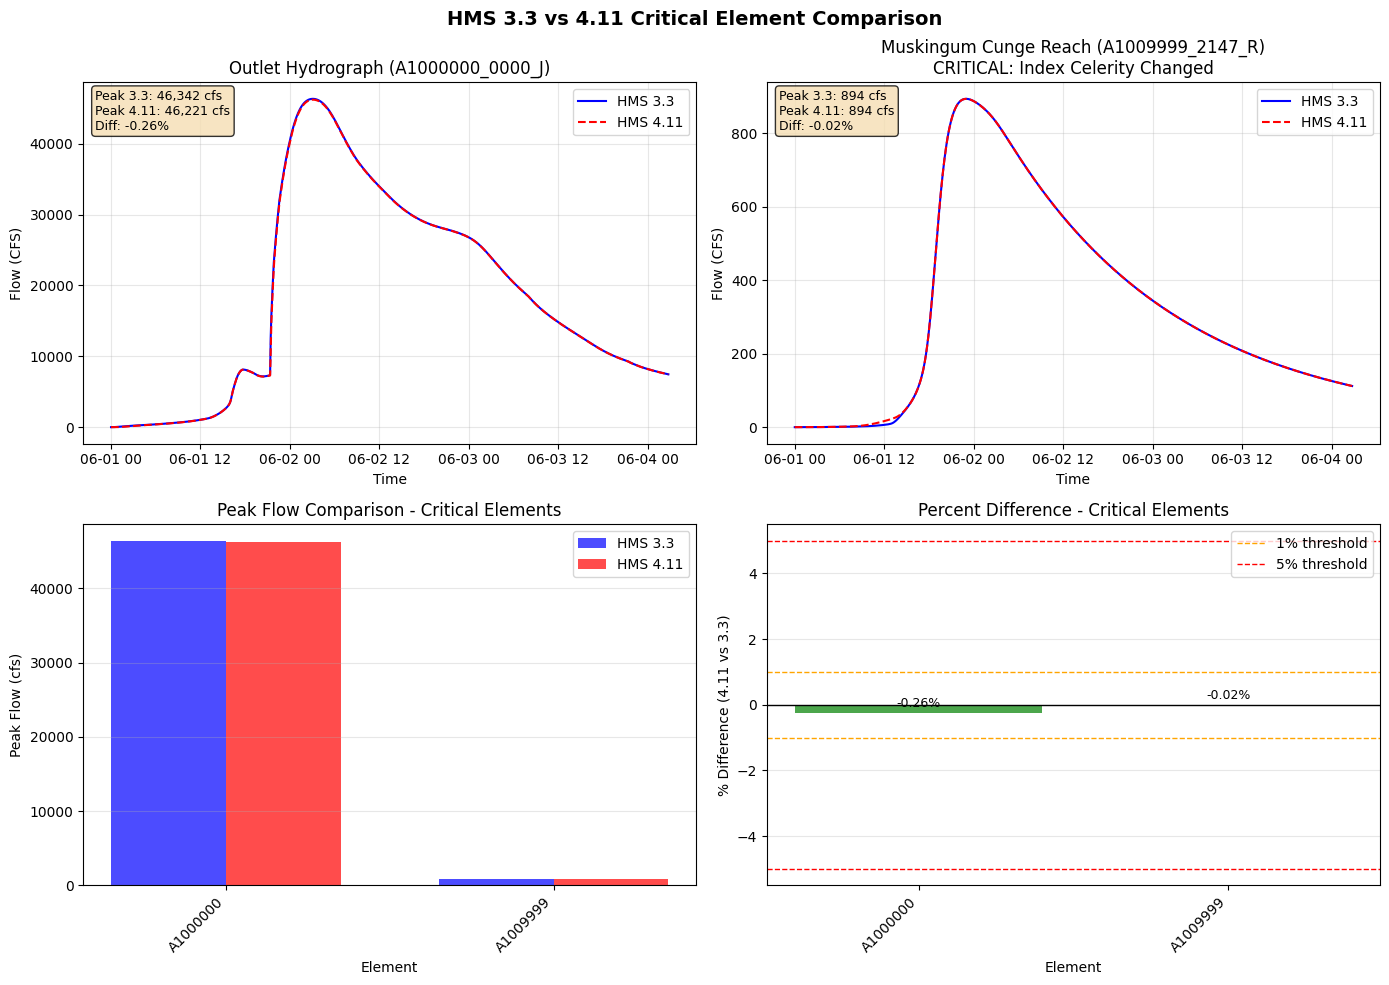

In [12]:
# Generate comparison figures for CRITICAL ELEMENTS
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('HMS 3.3 vs 4.11 Critical Element Comparison', fontsize=14, fontweight='bold')

# Subplot 1: Outlet hydrograph
ax1 = axes[0, 0]
outlet_path = [p for p in catalog_33 if 'A1000000_0000_J' in p and '/FLOW/' in p and '1%(100YR)RUN' in p][0]
ts_out_33 = HmsDss.read_timeseries(dss_33, outlet_path)
ts_out_411 = HmsDss.read_timeseries(dss_411, outlet_path)

ax1.plot(ts_out_33['datetime'], ts_out_33['value'], 'b-', label='HMS 3.3', linewidth=1.5)
ax1.plot(ts_out_411['datetime'], ts_out_411['value'], 'r--', label='HMS 4.11', linewidth=1.5)
ax1.set_xlabel('Time')
ax1.set_ylabel(f"Flow ({ts_out_33.attrs.get('units', 'cfs')})")
ax1.set_title('Outlet Hydrograph (A1000000_0000_J)')
ax1.legend()
ax1.grid(True, alpha=0.3)

peak_33 = ts_out_33['value'].max()
peak_411 = ts_out_411['value'].max()
diff_pct = (peak_411 - peak_33) / peak_33 * 100
ax1.text(0.02, 0.98, f'Peak 3.3: {peak_33:,.0f} cfs\nPeak 4.11: {peak_411:,.0f} cfs\nDiff: {diff_pct:+.2f}%',
        transform=ax1.transAxes, verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Subplot 2: Muskingum Cunge reach
ax2 = axes[0, 1]
reach_path = [p for p in catalog_33 if 'A1009999_2147_R' in p and '/FLOW/' in p and '1%(100YR)RUN' in p][0]
ts_reach_33 = HmsDss.read_timeseries(dss_33, reach_path)
ts_reach_411 = HmsDss.read_timeseries(dss_411, reach_path)

ax2.plot(ts_reach_33['datetime'], ts_reach_33['value'], 'b-', label='HMS 3.3', linewidth=1.5)
ax2.plot(ts_reach_411['datetime'], ts_reach_411['value'], 'r--', label='HMS 4.11', linewidth=1.5)
ax2.set_xlabel('Time')
ax2.set_ylabel(f"Flow ({ts_reach_33.attrs.get('units', 'cfs')})")
ax2.set_title('Muskingum Cunge Reach (A1009999_2147_R)\nCRITICAL: Index Celerity Changed')
ax2.legend()
ax2.grid(True, alpha=0.3)

peak_33 = ts_reach_33['value'].max()
peak_411 = ts_reach_411['value'].max()
diff_pct = (peak_411 - peak_33) / peak_33 * 100
ax2.text(0.02, 0.98, f'Peak 3.3: {peak_33:,.0f} cfs\nPeak 4.11: {peak_411:,.0f} cfs\nDiff: {diff_pct:+.2f}%',
        transform=ax2.transAxes, verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Subplot 3: Peak comparison bar chart
ax3 = axes[1, 0]
elements = comparison['element'].tolist()
x = np.arange(len(elements))
width = 0.35

bars1 = ax3.bar(x - width/2, comparison['peak_33'], width, label='HMS 3.3', color='blue', alpha=0.7)
bars2 = ax3.bar(x + width/2, comparison['peak_411'], width, label='HMS 4.11', color='red', alpha=0.7)

ax3.set_xlabel('Element')
ax3.set_ylabel('Peak Flow (cfs)')
ax3.set_title('Peak Flow Comparison - Critical Elements')
ax3.set_xticks(x)
ax3.set_xticklabels([e.split('_')[0] for e in elements], rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Subplot 4: Percent difference
ax4 = axes[1, 1]
colors = ['green' if abs(d) < 1 else 'orange' if abs(d) < 5 else 'red' for d in comparison['diff_pct']]
bars = ax4.bar(x, comparison['diff_pct'], color=colors, alpha=0.7)

ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.axhline(y=1, color='orange', linestyle='--', linewidth=1, label='1% threshold')
ax4.axhline(y=-1, color='orange', linestyle='--', linewidth=1)
ax4.axhline(y=5, color='red', linestyle='--', linewidth=1, label='5% threshold')
ax4.axhline(y=-5, color='red', linestyle='--', linewidth=1)

ax4.set_xlabel('Element')
ax4.set_ylabel('% Difference (4.11 vs 3.3)')
ax4.set_title('Percent Difference - Critical Elements')
ax4.set_xticks(x)
ax4.set_xticklabels([e.split('_')[0] for e in elements], rotation=45, ha='right')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, comparison['diff_pct']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{val:+.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Save figure
fig_path = project_411 / "version_comparison_figures.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"Comparison figure saved to: {fig_path}")

plt.show()

## Step 8: Save Modeling Change Log

In [13]:
# Add summary to log
modeling_log["summary"] = {
    "total_changes": len(modeling_log["changes"]),
    "total_warnings": len(modeling_log["warnings"]),
    "files_modified": list(set([c["file"] for c in modeling_log["changes"]])),
    "requires_engineer_review": len(modeling_log["warnings"]) > 0,
    "critical_elements": ["A1009999_2147_R (Muskingum Cunge reach)"]
}

# Save log to JSON
log_path = project_411 / "HMS_CONVERSION_LOG.json"
with open(log_path, 'w') as f:
    json.dump(modeling_log, f, indent=2)
print(f"Modeling log saved to: {log_path}")

# Also save human-readable version
log_txt_path = project_411 / "HMS_CONVERSION_LOG.txt"
with open(log_txt_path, 'w') as f:
    f.write("="*70 + "\n")
    f.write("HMS VERSION CONVERSION LOG\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Project: {modeling_log['project_name']}\n")
    f.write(f"Conversion Date: {modeling_log['conversion_date']}\n")
    f.write(f"Source Version: {modeling_log['source_version']}\n")
    f.write(f"Target Version: {modeling_log['target_version']}\n")
    f.write(f"Engineer Review Required: {modeling_log['summary']['requires_engineer_review']}\n\n")
    
    f.write("-"*70 + "\n")
    f.write("CHANGES MADE\n")
    f.write("-"*70 + "\n\n")
    
    for i, change in enumerate(modeling_log["changes"], 1):
        f.write(f"{i}. {change['category']}: {change['description']}\n")
        f.write(f"   File: {change['file']}\n")
        f.write(f"   Old: {change['old_value']}\n")
        f.write(f"   New: {change['new_value']}\n")
        f.write(f"   Expected Impact: {change['expected_impact']}\n\n")
    
    if modeling_log["warnings"]:
        f.write("-"*70 + "\n")
        f.write("WARNINGS - REQUIRE ENGINEER REVIEW\n")
        f.write("-"*70 + "\n\n")
        
        for i, warning in enumerate(modeling_log["warnings"], 1):
            f.write(f"{i}. {warning['message']}\n\n")
    
    if "muskingum_cunge_details" in modeling_log:
        f.write("-"*70 + "\n")
        f.write("MUSKINGUM CUNGE PARAMETER DETAILS\n")
        f.write("-"*70 + "\n\n")
        
        mc = modeling_log["muskingum_cunge_details"]
        f.write(f"Reach: {mc['reach_name']}\n")
        f.write(f"Method: {mc['routing_method']}\n")
        f.write(f"Channel: {mc['channel_type']}\n\n")
        
        f.write("PRESERVED Parameters:\n")
        for param, value in mc['parameters_preserved'].items():
            f.write(f"  {param}: {value}\n")
        
        f.write("\nMODIFIED Parameters:\n")
        for param, details in mc['parameters_modified'].items():
            f.write(f"  {param}: {details['old']} -> {details['new']}\n")
            f.write(f"    Reason: {details['reason']}\n")
        
        f.write("\nADDED Parameters (HMS 4.x requirements):\n")
        for param, value in mc['parameters_added'].items():
            f.write(f"  {param}: {value}\n")
    
    f.write("\n" + "="*70 + "\n")
    f.write("QAQC VERIFICATION CHECKLIST\n")
    f.write("="*70 + "\n\n")
    f.write("[ ] Compare outlet hydrograph peak and timing\n")
    f.write("[ ] Compare reach A1009999_2147_R inflow/outflow\n")
    f.write("[ ] Verify all subbasin peaks within 1% tolerance\n")
    f.write("[ ] Verify all junction peaks within 1% tolerance\n")
    f.write("[ ] Review Muskingum Cunge Index Celerity value\n")
    f.write("[ ] Sign-off by reviewing engineer\n\n")
    f.write(f"Engineer Signature: _____________________  Date: __________\n")

print(f"Human-readable log saved to: {log_txt_path}")

Modeling log saved to: c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00_HMS411\HMS_CONVERSION_LOG.json
Human-readable log saved to: c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00_HMS411\HMS_CONVERSION_LOG.txt


## Summary: Conversion Complete

### Changes Made

In [14]:
print("="*70)
print("CONVERSION SUMMARY")
print("="*70)
print(f"\nTotal changes made: {len(modeling_log['changes'])}")
print(f"Warnings requiring review: {len(modeling_log['warnings'])}")
print(f"\nFiles modified:")
for f in modeling_log['summary']['files_modified']:
    print(f"  - {f}")

print(f"\nCritical elements for verification:")
for elem in modeling_log['summary']['critical_elements']:
    print(f"  - {elem}")

print("\n" + "-"*70)
print("NEXT STEPS FOR ENGINEER:")
print("-"*70)
print("""
1. Open both DSS files in HEC-DSSVue
2. Compare outlet hydrographs (peak, timing, volume)
3. Compare reach A1009999_2147_R routing (attenuation, translation)
4. Verify Index Celerity = 5 fps is appropriate for channel
5. Document any differences > 1% in the conversion log
6. Sign off on QAQC checklist
""")

print("\nOutput files:")
print(f"  Conversion log (JSON): {project_411 / 'HMS_CONVERSION_LOG.json'}")
print(f"  Conversion log (TXT):  {project_411 / 'HMS_CONVERSION_LOG.txt'}")
if HAS_MATPLOTLIB:
    print(f"  Comparison figures:    {project_411 / 'version_comparison_figures.png'}")

CONVERSION SUMMARY

Total changes made: 3
Warnings requiring review: 1

Files modified:
  - 1__24HR.met
  - A100_0.2PCT.basin, A100_10PCT.basin, A100_1PCT.basin, A100_2PCT.basin
  - c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00_HMS411

Critical elements for verification:
  - A1009999_2147_R (Muskingum Cunge reach)

----------------------------------------------------------------------
NEXT STEPS FOR ENGINEER:
----------------------------------------------------------------------

1. Open both DSS files in HEC-DSSVue
2. Compare outlet hydrographs (peak, timing, volume)
3. Compare reach A1009999_2147_R routing (attenuation, translation)
4. Verify Index Celerity = 5 fps is appropriate for channel
5. Document any differences > 1% in the conversion log
6. Sign off on QAQC checklist


Output files:
  Conversion log (JSON): c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00_HMS411\HMS_CONVERSION_LOG.json
  Conversion log (TXT):  c:\GH\hms-commander\examples\Upgrade_M3

In [15]:
# Display the text log
print("\n" + "="*70)
print("FULL CONVERSION LOG")
print("="*70 + "\n")
print(log_txt_path.read_text())


FULL CONVERSION LOG

HMS VERSION CONVERSION LOG

Project: A100-00-00 (Clear Creek)
Conversion Date: 2025-12-25T03:46:48.437885
Source Version: HMS 3.3
Target Version: HMS 4.11
Engineer Review Required: True

----------------------------------------------------------------------
CHANGES MADE
----------------------------------------------------------------------

1. Project Setup: Created project copy for HMS 4.11 conversion
   File: c:\GH\hms-commander\examples\Upgrade_M3_to_4.13\A\A100-00-00_HMS411
   Old: N/A
   New: Copy of A100-00-00
   Expected Impact: None - working on copy preserves original

2. Met Model: Updated basin model reference from pattern to exact name
   File: 1__24HR.met
   Old: Use Basin Model: A100
   New: Use Basin Model: A100_1PCT
   Expected Impact: None - structural change only, same basin model used

3. Reach Routing: Updated Muskingum Cunge parameters for HMS 4.x compatibility
   File: A100_0.2PCT.basin, A100_10PCT.basin, A100_1PCT.basin, A100_2PCT.basin
   O